In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Scanning Astra evaluations

In [2]:
from astra import template_dir, evaluate_astra_with_distgen

import matplotlib.pyplot as plt

import numpy as np
import os

In [3]:
# Input files
ASTRA_IN = os.path.join(template_dir, 'dcgun/astra.in')
DISTGEN_IN = os.path.join(template_dir, 'dcgun/distgen.yaml')

In [4]:
# Run Astra with Distgen

# Basic settings
settings0 = {'zstop':1, 'zemit':10, 'zphase':10, 'phases':True}
settings0['n_particle'] = 2000

# Solenoid field
settings0['maxb(1)'] = 0.04

In [5]:
# This is the basic function we will use
outputs = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN)
outputs

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': -9.3606e-09,
 'end_sigma_x': 0.00034249000000000004,
 'end_sigma_xp': 0.00058495,
 'end_norm_emit_x': 1.7523e-07,
 'end_cov_x__xp': 1.7203272700000003e-07,
 'end_mean_y': -6e-09,
 'end_sigma_y': 0.00034237,
 'end_sigma_yp': 0.00058437,
 'end_norm_emit_y': 1.7449e-07,
 'end_cov_y__yp': 1.71972451e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 0.0021988,
 'end_sigma_energy': 1.7930000000000001,
 'end_norm_emit_z': 0.0039423,
 'end_cov_z__energy': 3.62714048e-05,
 'end_n_particle_loss': 0,
 'end_total_charge': 9.999999999999999e-11,
 'end_higher_order_energy_spread': 1.7928914838082946,
 'fingerprint': '5e598d95f02f5409ac6403da056f2ada'}

In [6]:
# Make a bare minimum function to evaluate
def f(b):
    s = settings0.copy()
    s['maxb(1)'] = b
    return evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                          distgen_input_file=DISTGEN_IN)
# Make a list to scan
blist = np.linspace(0, 0.1, 20)
f(0)

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': -9.5993e-09,
 'end_sigma_x': 0.00061591,
 'end_sigma_xp': 0.00065659,
 'end_norm_emit_x': 1.7486e-07,
 'end_cov_x__xp': 3.912075547e-07,
 'end_mean_y': -4.9541e-09,
 'end_sigma_y': 0.00061616,
 'end_sigma_yp': 0.0006571200000000001,
 'end_norm_emit_y': 1.7486999999999998e-07,
 'end_cov_y__yp': 3.9171139680000005e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 0.0021988,
 'end_sigma_energy': 1.7930000000000001,
 'end_norm_emit_z': 0.0039423,
 'end_cov_z__energy': 3.62318264e-05,
 'end_n_particle_loss': 0,
 'end_total_charge': 9.999999999999999e-11,
 'end_higher_order_energy_spread': 1.7928924976656841,
 'fingerprint': '96022eeab14dfd3442a2f82875271a88'}

In [7]:
# Get a parallel executor
#from concurrent.futures import ProcessPoolExecutor as Executor
from concurrent.futures import ThreadPoolExecutor as Executor
#from dask.distributed import Client as Executor

In [8]:
executor = Executor()
executor 

In [9]:
# Make a map object. Note that this does not execute immediately.
results = executor.map(f, blist)

In [10]:
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)
#    outputs.append(r.result())

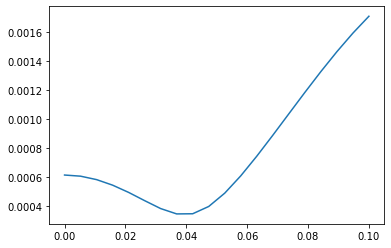

In [11]:
# Simple plot
plt.plot(blist, [o['end_sigma_x'] for o in outputs])

# Better: robust evaluation, form dataset 

In [12]:
from tempfile import TemporaryDirectory
SCRATCH=TemporaryDirectory()

In [13]:
# Make a robust evaluate
def evaluate(b):
    try:
        s = settings0.copy()
        s['maxb(1)'] = b
        output = evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN, archive_path=SCRATCH.name)
        # Add the input
        output['maxb(1)'] = b
        output['Exception'] = False
    except:
        output = {}
        output['maxb(1)'] = b
        output['Exception'] = True
        
    return output

In [14]:
SCRATCH.name

'/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmppr3zb58e'

In [15]:
# This will cause a crash in Astra
evaluate(1e9)

Run Aborted too many indices for array


{'maxb(1)': 1000000000.0, 'Exception': True}

In [16]:
# Get a new executor
executor =  Executor()

# Make a map object. Note that this does not execute immediately.

blist[-1] = 1e9 # Add something that will crash
results = executor.map(evaluate, blist)
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)

Run Aborted too many indices for array


In [17]:
# Archive files are here
os.listdir(SCRATCH.name)

['f3cb5e729ba51b6871398ade94e6b207.h5',
 'a21e928aa91d5b84a04eb3ced0435fd2.h5',
 'ea59cea47939e5db65a1e8233ba41aee.h5',
 '9e9450452311320dd3639a3dbb73d62d.h5',
 'de2c6412918b0474a68d0461d3489bde.h5',
 '8e95202b9387e41c985814e779c58095.h5',
 'e097e830ba9b3b334d5c57a797ef9df8.h5',
 '26ebdb39e8cf8fc7793068502cb7cb14.h5',
 'faf376747faa3697653f16d268aec2c1.h5',
 'c28fc2bbc0cec1038d83f6b78f662941.h5',
 'd5b5494773e0b584e67c51c77a0cf004.h5',
 '9a8e28c5cf89be4cee94690a7034b9c0.h5',
 '5527e0bb966fb44259c2d3769f26d7cf.h5',
 '9830959b046cbdad5353dd7fdba89a90.h5',
 'e5335871b78dae20ca8436e8570fbd8e.h5',
 'cd8b8ccf9e708947393c52fd6fa384e2.h5',
 '2527bdacafaf5ac7393f2eb588ac6649.h5',
 'fcd1d43f7c562c9eb81e292a48986aa8.h5',
 'e034ab0ed97377d097d95034231aeba5.h5']

# Pandas 

In [18]:
import pandas as pd

In [19]:
# Make a DataFrame
df = pd.DataFrame(outputs)
df

,error,end_mean_z,end_mean_t,end_mean_x,end_sigma_x,end_sigma_xp,end_norm_emit_x,end_cov_x__xp,end_mean_y,end_sigma_y,...,end_sigma_energy,end_norm_emit_z,end_cov_z__energy,end_n_particle_loss,end_total_charge,end_higher_order_energy_spread,fingerprint,archive,maxb(1),Exception
0,False,1.0,4.015600e-09,-9.599300e-09,0.000616,0.000657,1.748600e-07,3.912076e-07,-4.954100e-09,0.000616,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,c28fc2bbc0cec1038d83f6b78f662941,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,0.000000e+00,False
1,False,1.0,4.015600e-09,-8.978400e-09,0.000608,0.000647,1.749600e-07,3.800855e-07,-5.860000e-09,0.000608,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,2527bdacafaf5ac7393f2eb588ac6649,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,5.263158e-03,False
2,False,1.0,4.015600e-09,-8.389500e-09,0.000584,0.000621,1.750400e-07,3.479737e-07,-6.400000e-09,0.000584,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,5527e0bb966fb44259c2d3769f26d7cf,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.052632e-02,False
3,False,1.0,4.015600e-09,-7.936600e-09,0.000546,0.000581,1.751100e-07,3.001472e-07,-6.622200e-09,0.000545,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,cd8b8ccf9e708947393c52fd6fa384e2,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.578947e-02,False
4,False,1.0,4.015600e-09,-7.717000e-09,0.000496,0.000536,1.751700e-07,2.450736e-07,-6.598000e-09,0.000495,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,e5335871b78dae20ca8436e8570fbd8e,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.105263e-02,False
5,False,1.0,4.015600e-09,-7.767700e-09,0.000439,0.000499,1.752100e-07,1.937792e-07,-6.423200e-09,0.000438,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,d5b5494773e0b584e67c51c77a0cf004,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.631579e-02,False
6,False,1.0,4.015600e-09,-8.131300e-09,0.000384,0.000492,1.752300e-07,1.590813e-07,-6.198100e-09,0.000384,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,faf376747faa3697653f16d268aec2c1,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.157895e-02,False
7,False,1.0,4.015600e-09,-8.810900e-09,0.000348,0.000534,1.752300e-07,1.546022e-07,-6.030000e-09,0.000347,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792892,a21e928aa91d5b84a04eb3ced0435fd2,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.684211e-02,False
8,False,1.0,4.015600e-09,-9.780200e-09,0.000349,0.000629,1.752200e-07,1.937337e-07,-6.022400e-09,0.000348,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792891,9a8e28c5cf89be4cee94690a7034b9c0,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.210526e-02,False
9,False,1.0,4.015600e-09,-1.098900e-08,0.000399,0.000768,1.751800e-07,2.885824e-07,-6.252600e-09,0.000399,...,1.793,0.003942,0.000036,0.0,1.000000e-10,1.792891,9830959b046cbdad5353dd7fdba89a90,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.736842e-02,False


In [20]:
# Get all runs without an exeption
filtered_df=df[~df['Exception']]

# Visualize with Bokeh

In [21]:
from bokeh.plotting import figure, output_notebook, show

from bokeh.models import ColumnDataSource

# Allows plots to show up in the notebook
output_notebook()

Loading BokehJS ...

In [22]:
# Form a Bokeh style data source
source = ColumnDataSource(filtered_df)
source.column_names

['index',
 'error',
 'end_mean_z',
 'end_mean_t',
 'end_mean_x',
 'end_sigma_x',
 'end_sigma_xp',
 'end_norm_emit_x',
 'end_cov_x__xp',
 'end_mean_y',
 'end_sigma_y',
 'end_sigma_yp',
 'end_norm_emit_y',
 'end_cov_y__yp',
 'end_mean_kinetic_energy',
 'end_sigma_z',
 'end_sigma_energy',
 'end_norm_emit_z',
 'end_cov_z__energy',
 'end_n_particle_loss',
 'end_total_charge',
 'end_higher_order_energy_spread',
 'fingerprint',
 'archive',
 'maxb(1)',
 'Exception']

In [23]:
# A simple plot
p = figure()
p.circle(x='maxb(1)', y='end_sigma_x', source=source)
show(p)

In [24]:
# Fancier plot

from bokeh.models.tools import HoverTool

hover = HoverTool()


hover.tooltips=[
    ('sigma_x', '@end_sigma_x'),
    ('norm_emit_x', '@end_norm_emit_x'),
    ('archive', '@archive')
]
p = figure(tools='tap')
p.circle(x='maxb(1)', y='end_sigma_x', source=source, size=10, color='green')

p.add_tools(hover)

show(p)

In [25]:
# Load all archives
from astra import Astra
Alist = []
for a in filtered_df['archive']:
    A = Astra()
    A.load_archive(a)
    Alist.append(A)

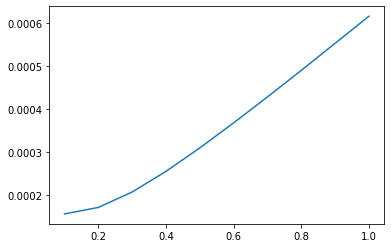

In [26]:
plt.plot(
    Alist[0].output['stats']['mean_z'],
    Alist[0].output['stats']['sigma_x']
)